In [2]:
import sys 
sys.path.append("../")

from rl.chapter2.simple_inventory_mrp import *
import itertools
import numpy as np
from pprint import pprint
from rl.returns import returns
import rl.markov_process as mp
import matplotlib.pyplot as plt 
from rl.distribution import Choose
from collections import defaultdict
from typing import Iterable, TypeVar, Dict, Mapping, Callable
from rl.approximate_dynamic_programming import ValueFunctionApprox
from rl.function_approx import Gradient, Tabular, learning_rate_schedule
from rl.chapter10.prediction_utils import fmrp_episodes_stream, unit_experiences_from_episodes

**Question 2**

Implemented Tabular TD lambda for Prediction below. TD lambda with approximation is already available in the codebase. 



In [3]:
S = TypeVar("S")
alpha=0.03

def tabular_td_lambda(traces: Iterable[Iterable[mp.TransitionStep[S]]], vf : Mapping[S, float], 
                              gamma = 0.9,
                              lambd = 0.2) -> Iterable[Mapping[S, float]]:
    
    for i, trace in enumerate(traces):
        el_tr = {s : 0.0 for s in vf}
        for step in trace:
            el_tr = {s : el_tr[s] * gamma * lambd + (1.0 if step.state == s else 0.0) for s in el_tr}
            td_error = step.reward + gamma * vf[step.next_state] - vf[step.state]
            vf = {s : vf[s] + alpha* td_error * el_tr[s] for s in vf}
            yield vf

**Question 4**

First, comparing the value funcitons from Tabular TD lambda and DP.

Then plotting the convergence of Tabular TD lambda for different values of lambda.

In [28]:
#Initializing the simple inventory mrp
capacity = 2
poisson_lambda = 1.0
holding_cost = 1.0
stockout_cost = 10.0
gamma=0.9

si_mrp = SimpleInventoryMRPFinite(capacity=capacity,
                                  poisson_lambda=poisson_lambda,
                                  holding_cost=holding_cost,
                                  stockout_cost=stockout_cost)
print("DP solution")
si_mrp.display_value_function(gamma=gamma)
actual_vf = si_mrp.get_value_function_vec(gamma=gamma)


DP solution
{NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -30.345,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -27.932,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -28.345,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -29.345,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -28.932,
 NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -35.511}


In [29]:
num_traces = 100
num_episodes = 1000

traces = si_mrp.reward_traces(Choose(si_mrp.non_terminal_states))
init_vf= {s : 0.0 for s in si_mrp.non_terminal_states}
vf_it = tabular_td_lambda(traces=traces, vf=init_vf, 
                                  gamma=gamma, lambd = 0.6)

*_, final_vf = itertools.islice(vf_it, num_traces * num_episodes)
print("Tabular TD lambda")

pprint({s : round(final_vf[s], 3) for s in si_mrp.non_terminal_states})
print()

Tabular TD lambda
{NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -29.645,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -27.909,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -28.626,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -29.235,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -29.371,
 NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -35.844}



In [30]:
lambdas = list(range(0,11))
final_error=[]
for i in range(len(lambdas)):
    td_vf_err = []
    v1 = tabular_td_lambda(traces=traces, vf=init_vf, 
                                  gamma=gamma, lambd = lambdas[i]/10)
    op = list(itertools.islice(v1,10000))
    for ele in op:
        err= abs(ele[NonTerminal(state=InventoryState(on_hand=0, on_order=0))]+35.511)
        td_vf_err.append(err)
    final_error.append(td_vf_err)
 




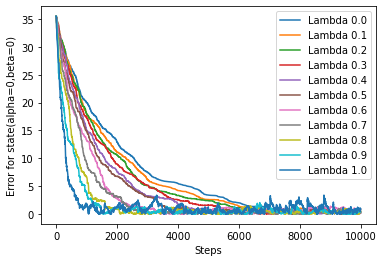

In [24]:
for i in range(len(lambdas)):
    plt.plot(final_error[i],label='Lambda '+str(lambdas[i]/10))
plt.xlabel("Steps")
plt.ylabel("Error for state(alpha=0,beta=0)")
plt.legend()
plt.show()

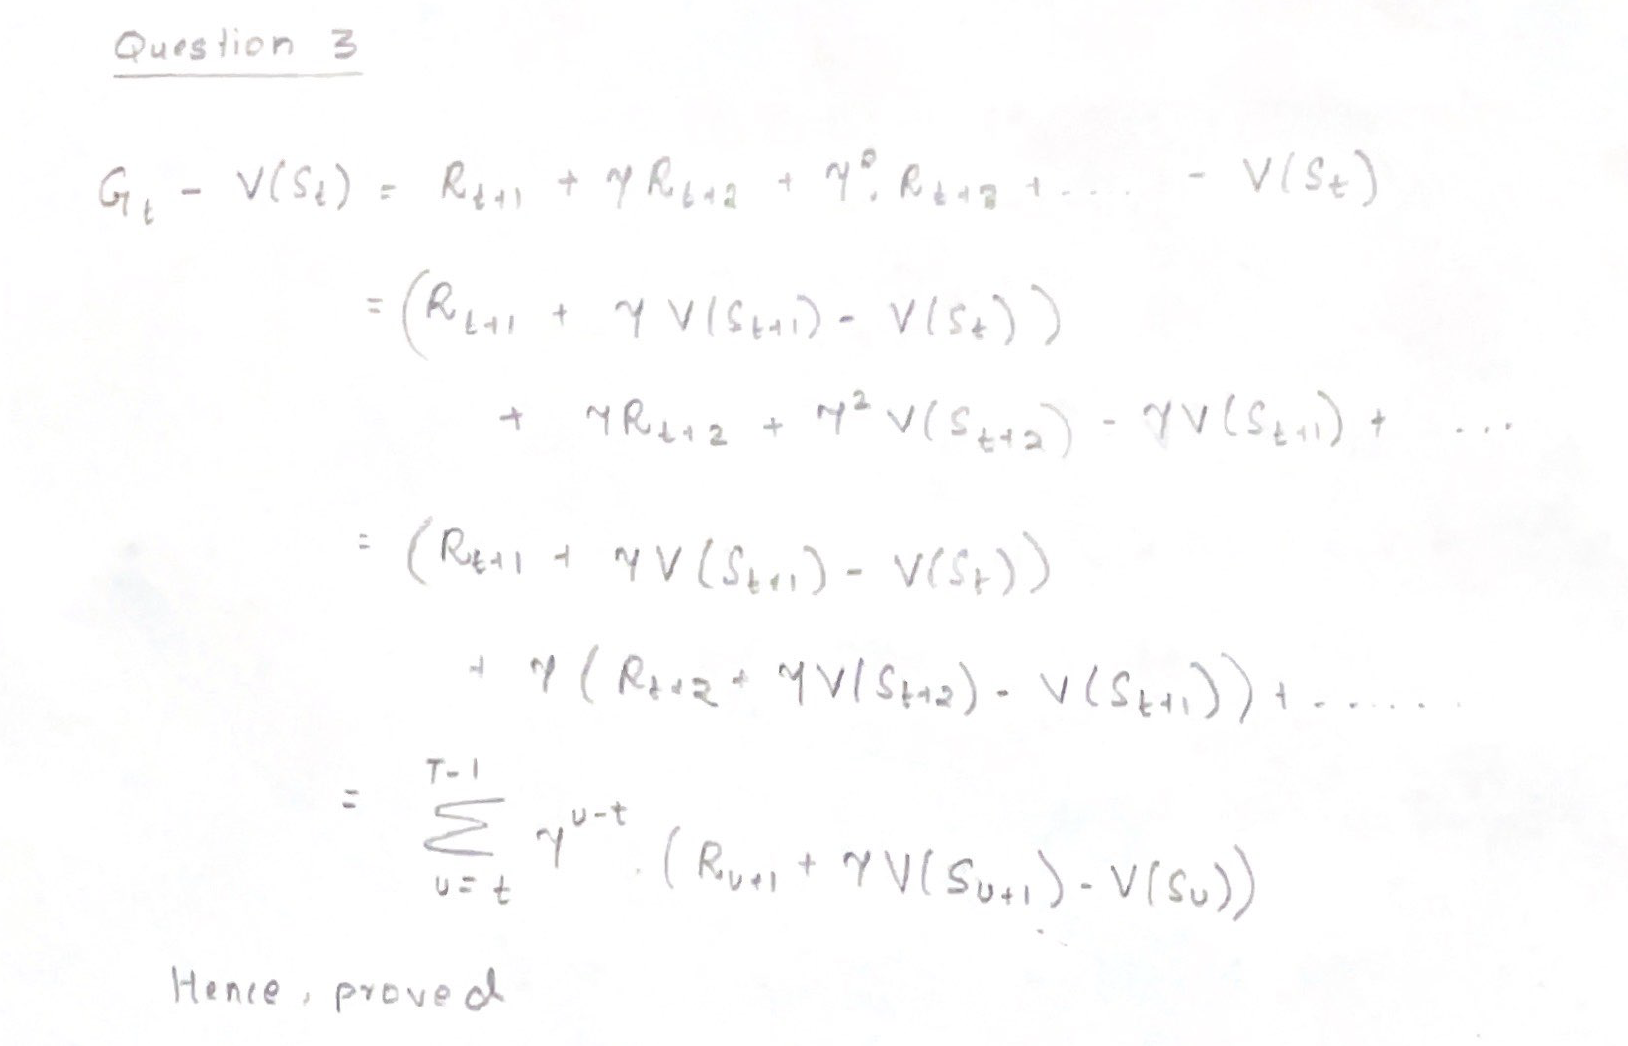